In [1]:
%matplotlib inline

#import packages required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import problems_unittests as tests
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy.ma as ma
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

In [4]:
#reading csv files in pandas dataframe

train_df = pd.read_csv('training.csv')
train_df = shuffle(train_df) ##shuffling the data as I will not approach as a time series problem

test_df = pd.read_csv('test.csv')

In [5]:
train_df.head()

,timestamp,app,updated_at,detected_app,name,window,created_at,project_id,created_from
76562,2018-03-14 14:13:20,Slack,2018-03-15 08:01:02,Slack,Memory,Slack - Memory,2018-03-15 08:00:32,2463090,Web
7122,2018-03-12 09:59:26,PyCharm,2018-03-13 08:10:53,PyCharm,PyCharm,ai-experiments [~/PycharmProjects/ai-experimen...,2018-03-13 08:09:21,2463090,Web
84291,2018-03-14 16:23:53,PyCharm,2018-03-15 08:00:53,PyCharm,PyCharm,ai-experiments [~/PycharmProjects/ai-experimen...,2018-03-15 08:00:53,2463090,Web
3757,2018-03-12 09:02:00,Slack,2018-03-13 08:10:44,Slack,Memory,Slack - Memory,2018-03-13 08:10:39,2463951,Web
185515,2018-03-21 16:06:14,PyCharm,2018-03-22 11:26:56,PyCharm,PyCharm,ai-experiments [~/PycharmProjects/ai-experimen...,2018-03-22 11:26:56,2463090,Web


The above is the training dataframe. I will separate out the "project_id" from the features to use id as a label along with encoding it. Below is the label distribution;

In [4]:
train_df['project_id'].value_counts()

2463090    212503
2533532     15391
2463951      6560
2463103      5301
2463091      4201
Name: project_id, dtype: int64

In [5]:
def labels(df):
    """
    Args:
    df: Pandas DataFrame of input file
    Return: list of labels 
    """
    encoding_map = {2463091:0, 2463103:1, 2463951:2, 2533532:3, 2463090:4} 
    #large integers take up memory so encoding with single digit
    df = df['project_id'].replace(encoding_map)
    return df

tests.test_labels(labels)

Tests Passed


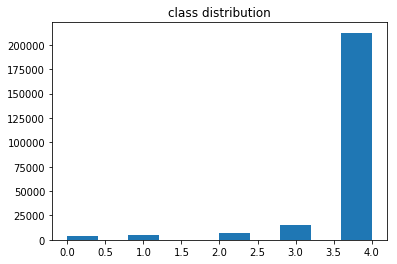

In [6]:
train_y = labels(train_df)
test_y = labels(test_df)


plt.hist(train_y)
plt.title("class distribution");

As we can see the distribution of the labels is imbalanced so the accuracy level may not always be the appropriate metrics. There can be other better metrics like Precision, Recall, F1 score, ROC AUC or Confusion Matrix which may indicate if the model is performing good or not.

We use these metrics that tell us the number of false positives and false negatives.

This means that we should optimize for:

high recall (true positive rate) low fall-out (false positive rate)

We can calculate false positive rate and true positive rate, using the numbers of true positives, true negatives, false negatives, and false positives.

False positive rate is the number of false positives divided by the number of false positives plus the number of true negatives.

fpr = fp / (fp + tn)

True positive rate is the number of true positives divided by the number of true positives plus the number of false negatives.

tpr = tp / (tp + fn)

Reference https://www.dataquest.io

The ROC Curve has the True Positive Rate tpr on the y-axis and the False Positive Rate fpr on the x-axis of a plot.


## Which features did you select? Why?


Checking if the "app", "detected_app" and "name" columns have same values across rows. "app" and "detected_app" are same across all the rows. As a result, I decided to drop "detected_app" feature

In [7]:
train_df['app'].equals(train_df['detected_app'])

True

In [8]:
train_df['app'].equals(train_df['name'])

False

"app" feature seems to be a condensed information of "name" column so I will drop "app" feature.

In [9]:
train_df['name'].unique()

array(['github.com', 'wildml.com', 'PyCharm', 'calendar.google.com',
       'zoom.us', 'TextEdit', 'iTerm2', 'Basecamp 3',
       'amplitude.zendesk.com', 'memory.workable.com', 'bigmarker.com',
       'Memory', 'Slack', 'noop.in', 'Calendar', 'Mail',
       'stackoverflow.com', 'no.ambafrance.org', 'app.clubhouse.io',
       'Skype', 'outlook.live.com', 'Finder', 'tutorialspoint.com',
       'Preview', 'blog.echen.me', 'app.fullstory.com', 'Python',
       'arxiv.org', 'MySQLWorkbench', 'Notes', 'docs.google.com',
       'psutil.readthedocs.io', 'app.timelyapp.com', 'docs.python.org',
       'dont-be-afraid-to-commit.readthedocs.io', 'app.intercom.io',
       'analytics.amplitude.com', 'intellij-support.jetbrains.com',
       'tensorflow.org', 'Untitled', 'skype.com', 'bbc.com',
       'youtube.com', 'docs.scipy.org', 'developer.atlassian.com',
       '127.0.0.1', 'thegeekstuff.com',
       'leonardoaraujosantos.gitbooks.io', 'git-scm.com', 'finn.no',
       'Evernote', 'dev.mysql.com

In [10]:
train_df['app'].unique()

array(['Google Chrome', 'PyCharm', 'zoom.us', 'TextEdit', 'iTerm2',
       'Basecamp 3', 'Slack', 'Calendar', 'Mail', 'Skype', 'Finder',
       'Preview', 'Python', 'MySQLWorkbench', 'Notes', 'Pages',
       'Evernote', 'Mendeley Desktop', 'Acrobat Reader', 'IDLE',
       'Dashlane', 'Reminders', 'Sonos', 'Calculator', 'coreautha',
       'System Preferences', 'CoreServicesUIAgent', 'Activity Monitor',
       'Evernote Helper', 'VoiceOver Quickstart',
       'Memory Tracker by Timely'], dtype=object)

"web" has just one value for all the rows so dropping that as well.

In [11]:
print(train_df['created_from'].value_counts())

Web    243956
Name: created_from, dtype: int64


Looking for missing values across all the columns

In [12]:
for col in train_df.columns.values:
    print()
    print("Number of Nulls in column of", col)
    print(train_df[col].isnull().value_counts())


Number of Nulls in column of timestamp
False    243956
Name: timestamp, dtype: int64

Number of Nulls in column of app
False    243956
Name: app, dtype: int64

Number of Nulls in column of updated_at
False    243956
Name: updated_at, dtype: int64

Number of Nulls in column of detected_app
False    243956
Name: detected_app, dtype: int64

Number of Nulls in column of name
False    243956
Name: name, dtype: int64

Number of Nulls in column of window
False    234246
True       9710
Name: window, dtype: int64

Number of Nulls in column of created_at
False    243956
Name: created_at, dtype: int64

Number of Nulls in column of project_id
False    243956
Name: project_id, dtype: int64

Number of Nulls in column of created_from
False    243956
Name: created_from, dtype: int64


There are missing values only in the window column. 

I will create 2 features;

1. rows that contains missing values in "window" feature is encoded as 1 else 0
2. rows with "app" and "name" columns values not matched are encoded as 1 else 0

In [13]:
train_df['missing_apps'] = train_df['app'][train_df['app'] != train_df['name']]
test_df['missing_apps'] = test_df['app'][test_df['app'] != test_df['name']]

In [14]:
train_df['missing_apps'] = train_df['missing_apps'].isnull().astype(int)
test_df['missing_apps'] = test_df['missing_apps'].isnull().astype(int)

In [15]:
train_df['window_missing'] = train_df['window'].isnull().astype(int)
test_df['window_missing'] = test_df['window'].isnull().astype(int)

#### I wanted to solve the problem as with the time series analysis by making the use of the time-based features ("timestamps" or "created_at" time features). I wanted to put the features of the previous timestamps as a lag using `pandas.shift` method but I noticed that many rows were duplicated if we treat timestamps as an unique identifers. So I thought of dropping the duplicated rows after dropping timestamps and approaching this problem as text analysis instead. I also felt that rows may not neccessarily be related to each other so it may not be time series problem in the first place. The training rows decreased from 243956 to 2768. As a result, I have to keep in mind about the curse of dimensionality while crafting more features.

In [16]:
def extract_data(df, train_set=True):
    """
    Args: df: DataFrame
    train: Flag if it the data is training set or not
    return DataFrame with columns to be used
    """
    
    #df = df.drop(['project_id', 'timestamp', 'detected_app' ], axis=1)
    df = df.drop(['timestamp', 'detected_app', 'created_from', 'app'], axis=1)
    if train_set:
        df = df.drop_duplicates()
    #converting the datetimed feature as datetime datatype instead of object
    df['created_at'] = pd.DatetimeIndex(df['created_at'])
    df['updated_at'] = pd.DatetimeIndex(df['updated_at'])
    
    return df

tests.test_extract_data(extract_data)

Tests Passed


In [17]:
train_x = extract_data(train_df)
test_x = extract_data(test_df, train_set=False)

In [18]:
test_x.shape

(30885, 7)

In [19]:
train_x.shape

(2768, 7)

Created additional features out of time;

1. Difference between "updated" and created time duration
2. Extract "minutes" and "seconds" for both features
3. Extract "days", "hour", and "week" of "created_at" feature 

In [20]:
train_x['update_duration'] = (train_x['updated_at'].values - train_x['created_at'].values) / np.timedelta64(1, 's')

test_x['update_duration'] = (test_x['updated_at'].values - test_x['created_at'].values) / np.timedelta64(1, 's')

In [21]:
print(train_x['created_at'].dt.year.value_counts())
print(train_x['updated_at'].dt.year.value_counts())

2018    2768
Name: created_at, dtype: int64
2018    2768
Name: updated_at, dtype: int64


In [22]:
print(train_x['created_at'].dt.month.value_counts())
print(train_x['updated_at'].dt.month.value_counts())

3    2768
Name: created_at, dtype: int64
3    2768
Name: updated_at, dtype: int64


It looks like within the same "hour"/"day"/"week" all the projects get created and updated. So I will consider only one feature of "created_at" for "hour"/"day"/"week"

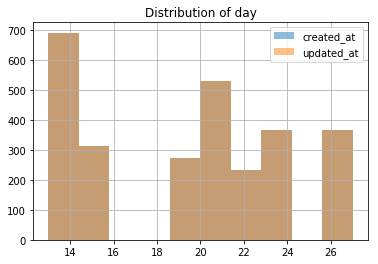

In [23]:
train_x['created_at'].dt.day.hist(alpha=0.5, label='created_at')
train_x['updated_at'].dt.day.hist(alpha=0.5, label='updated_at')
plt.title("Distribution of day")
plt.legend();

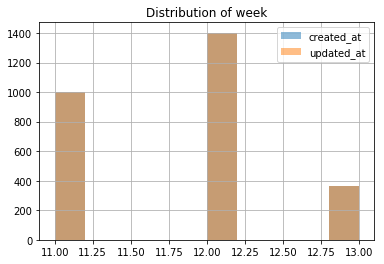

In [24]:
train_x['created_at'].dt.week.hist(alpha=0.5, label='created_at')
train_x['updated_at'].dt.week.hist(alpha=0.5, label='updated_at')
plt.title("Distribution of week")
plt.legend();

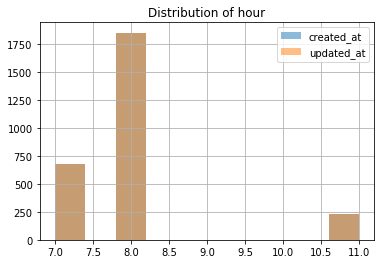

In [25]:
train_x['created_at'].dt.hour.hist(alpha=0.5, label='created_at')
train_x['updated_at'].dt.hour.hist(alpha=0.5, label='updated_at')
plt.title("Distribution of hour")
plt.legend();

Distibution of "minutes" look slightly different for both. So I will create 2 features ("minutes" and "seconds") out of "created_at" and "updated_at" columns

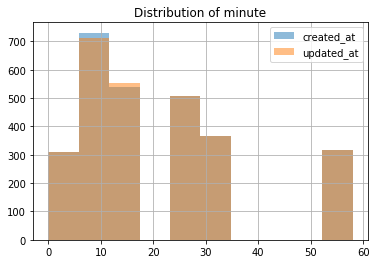

In [26]:
train_x['created_at'].dt.minute.hist(alpha=0.5, label='created_at')
train_x['updated_at'].dt.minute.hist(alpha=0.5, label='updated_at')
plt.title("Distribution of minute")
plt.legend();

In [27]:
train_x['created_at_day'] = train_x['created_at'].dt.day
train_x['created_at_week'] = train_x['created_at'].dt.week
train_x['created_at_hour'] = train_x['created_at'].dt.hour

test_x['created_at_day'] = test_x['created_at'].dt.day
test_x['created_at_week'] = test_x['created_at'].dt.week
test_x['created_at_hour'] = test_x['created_at'].dt.hour


train_x['created_at_mins'] = train_x['created_at'].dt.minute
train_x['updated_at_mins'] = train_x['updated_at'].dt.minute

test_x['created_at_mins'] = test_x['created_at'].dt.minute
test_x['updated_at_mins'] = test_x['updated_at'].dt.minute


train_x['created_at_secs'] = train_x['created_at'].dt.second
train_x['updated_at_secs'] = train_x['updated_at'].dt.second

test_x['created_at_secs'] = test_x['created_at'].dt.second
test_x['updated_at_secs'] = test_x['updated_at'].dt.second

In [28]:
### The below is to create the Pre-processed files to be fed into the LSTM model

In [29]:
#train_x.to_csv('processed_train.csv', index=None)
#test_x.to_csv('processed_test.csv', index=None)

In [30]:
test_x.shape

(30885, 15)

In [31]:
train_x.shape

(2768, 15)

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import re
from bs4 import BeautifulSoup

def process_text(text):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = re.sub(r"[^a-zA-Z]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    #words = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]
    
    return " ".join(words)

tests.test_process_text(process_text)

Tests Passed


process_text function allows us to tokenize the words found in a window feature, for example, converting entertained and entertaining into entertain so that they are treated as though they are the same word. That's called stemming.

This function converts the Uppercase words into the lower case. For example, Mountain has changed into mountain.

This function removes stopwords. for example, common words like "it", "this", "the" have been removed.

This method also splits the entire sentence into the words.

A regular expression, or Regex for short, allows us to search for patterns in text in a fast and automated manner.

text = re.sub(r"[^a-zA-Z]", " ", text.lower())

In above line of code, regex finds the pattern of text with alphabetical characters and so it removes the non-alphabetical characters like numbers, punctuation. The non-alphabetical characters have been removed from the text in the pre-processing steps.

In the above line of code, I filled NAs with 'missingvaluesoverhere' here and applied process_text function across all the rows of "window" feature

In [40]:
train_x['preprocessed_window'] = train_x['window'].fillna('missingvaluesoverhere').apply(process_text)
test_x['preprocessed_window'] = test_x['window'].fillna('missingvaluesoverhere').apply(process_text)


In [41]:
train_x['preprocessed_window']

0                                                      note
34                                             blooper reel
37                                       answer bright idea
64                                               epic phase
79        answer read book watch tv show movi late want ...
88                                     missingvaluesoverher
90                                     missingvaluesoverher
93                                     missingvaluesoverher
94                                      inbox messag unread
97                                      inbox messag unread
99                                             inbox messag
119                                    missingvaluesoverher
124                                    missingvaluesoverher
133                                          welcom pycharm
176       relax sunday morn indi folk pop playlist vol y...
177                                                  youtub
181                                     

#### Building Bag of Words of the above pre-processed text feature

A bag of words technique uses a vocabulary consisting of the most frequently appearing words in a set of documents. Then, for each word in the vocabulary we record the number of times that word appears

In [42]:
vectorizer = CountVectorizer(max_features=150) #max_features can be tuned
X = vectorizer.fit(train_x['preprocessed_window'])

In [43]:
train_text = pd.DataFrame(X.transform(train_x['preprocessed_window']).toarray(), index=train_x.index)
train_text = train_text.rename(columns={v:k for k, v in X.vocabulary_.items()})

test_text = pd.DataFrame(X.transform(test_x['preprocessed_window']).toarray(), index=test_x.index)
test_text = test_text.rename(columns={v:k for k, v in X.vocabulary_.items()})

In [44]:
train_data = pd.concat([train_x, train_text], axis=1)
test_data = pd.concat([test_x, test_text], axis=1)

test_data['preprocessed_window']

0                               note
1                               note
2                               note
3              activ monitor process
4               missingvaluesoverher
5               missingvaluesoverher
6               missingvaluesoverher
7               missingvaluesoverher
8               missingvaluesoverher
9               missingvaluesoverher
10              missingvaluesoverher
11             activ monitor process
12                                  
13                              note
14                              note
15                              note
16                              note
17                              note
18                              note
19              missingvaluesoverher
20                                  
21                              note
22                              note
23                              note
24               inbox messag unread
25               inbox messag unread
26                      inbox messag
2


## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The resulting one-hot encoded matrix will have almost all of the resulting values be zero. This a huge waste of computation. 

<img src="lookup_matrix.png">

Instead of doing the matrix multiplication, we use the matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get embeded values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of embedding size is the **embedding dimension**.

<img src="tokenize_lookup.png" width=250>
 
 
Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

Reference https://github.com/udacity/deep-learning/blob/master/embeddings/Skip-Grams-Solution.ipynb


In [ ]:
### Here's the lower level vectorized implementation of word embedding

In [45]:
def embedding(train_col, test_col, num_embed):
    one = OneHotEncoder(handle_unknown='ignore')
    one.fit(train_col)
    train_indices = one.transform(train_col).toarray()
    embedding_mat = np.random.rand(train_indices.shape[1],num_embed)
    
    train_embed = pd.DataFrame(np.dot(train_indices, embedding_mat), 
                               index = train_col.index)
    
    test_indices = one.transform(test_col).toarray()
    test_embed = pd.DataFrame(np.dot(test_indices, embedding_mat),
                              index=test_col.index)
    
    return train_embed, test_embed

### Here's the display of the embeded word representation

```
def embedding(train_col, test_col, num_embed):
    one = OneHotEncoder(handle_unknown='ignore')
    one.fit(train_col)
    train_indices = one.transform(train_col).toarray()
    embedding_mat = np.random.rand(train_indices.shape[1],num_embed)
    
    train_embed = pd.DataFrame(np.dot(train_indices, embedding_mat))
    
    test_indices = one.transform(test_col).toarray()
    test_embed = pd.DataFrame(np.dot(test_indices, embedding_mat))
    
    return train_embed, test_embed
```

```
col1 = np.array(['hello', 'cat', 'mouse', 'dog'])
col2 = np.array(['dog', 'cat', 'mouse', 'hello'] )
```

In [70]:
#em = embedding(col1.reshape(-1,1), col2.reshape(-1,1), 3)
#em[0]

,0,1,2
0,0.251996,0.413808,0.036066
1,0.100951,0.342217,0.225306
2,0.917061,0.915917,0.760909
3,0.599521,0.351375,0.222859


In [71]:
#em[1]

,0,1,2
0,0.599521,0.351375,0.222859
1,0.100951,0.342217,0.225306
2,0.917061,0.915917,0.760909
3,0.251996,0.413808,0.036066


#### Embedding has been applied to the "name" feature of the data. Because there were many unique words in the "name" column and one-hot encoding will result in many dimension so that's why I decided to apply embedding instead. 

In [46]:
## Embedding size is 30 which can be tuned
train_app, test_app = embedding(train_data[['name']], test_data[['name']],  30)

### Drop all the text/time based columns after extracting the useful/encoded features

In [47]:
train_y = train_data['project_id']
test_y = test_data['project_id']

train_data.drop(['updated_at', 'created_at','name', 'window', 'preprocessed_window', 'project_id'], axis=1, inplace=True)
test_data.drop(['updated_at', 'created_at', 'name', 'window', 'preprocessed_window', 'project_id'], axis=1, inplace=True)


In [48]:
train_data.shape

(2768, 158)

In [49]:
test_data.shape

(30885, 158)

In [50]:
train_data.columns.values

array(['missing_apps', 'window_missing', 'update_duration',
       'created_at_day', 'created_at_week', 'created_at_hour',
       'created_at_mins', 'updated_at_mins', 'created_at_secs',
       'updated_at_secs', 'accept', 'account', 'action', 'activ', 'adam',
       'ai', 'amplitud', 'applic', 'auto', 'base', 'bash', 'beauti',
       'branch', 'calendar', 'changelog', 'chill', 'clubhous', 'code',
       'com', 'commit', 'compar', 'criterion', 'data', 'databas', 'day',
       'develop', 'directori', 'document', 'download', 'dropout', 'end',
       'engin', 'error', 'except', 'experi', 'file', 'finn', 'fix',
       'free', 'fullstori', 'function', 'gener', 'get', 'git', 'github',
       'gitpython', 'googl', 'gp', 'gradient', 'graph', 'guid',
       'hierarchi', 'hour', 'id', 'inbox', 'integr', 'intercom', 'ip',
       'issu', 'item', 'job', 'learn', 'linux', 'log', 'machin', 'manual',
       'march', 'market', 'master', 'matplotlib', 'mean', 'meet',
       'memori', 'merg', 'messag', '

### Concatenating dataframe with the embedding of the  "name" feature

In [51]:
train_data = pd.concat([train_data, train_app], axis=1)
test_data = pd.concat([test_data, test_app], axis=1)

In [58]:
train_data.shape

(2768, 188)

In [59]:
test_data.shape

(30885, 188)

In [60]:
## One hot encoding the labels

In [61]:
le = OneHotEncoder()
train_y_enc = le.fit_transform(np.array(train_y).reshape(-1,1)).toarray()
test_y_enc = le.transform(np.array(test_y).reshape(-1,1)).toarray()

/home/rahul/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [62]:
test_y_enc.shape

(30885, 5)

In [63]:
train_y_enc.shape

(2768, 5)

### What are the results on the test dataset?
### Which model(s) did you select? Why?

The below is the XGBoost Classifier's test dataset results in terms of confusion metrics where the minority samples are being classified to some extent. In the test data, there are only 2 class labels. Whereas in the training data there are 5 class labels.

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 

It is an implementation of gradient boosting machines. Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In Boosting, 
1. we first model data with simple models and analyze data for errors. 
2. These errors signify data points that are difficult to fit by a simple model. 
3. Then for later models, we particularly focus on those hard to fit data to get them right. 
4. In the end, we combine all the predictors by giving some weights to each predictor.

References;

https://xgboost.readthedocs.io/en/latest/

https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

In [65]:
def _print_results(clf):
    print("model training accuracy score: %.3f" % clf.score(train_data, train_y))
    print("model testing accuracy score: %.3f" % clf.score(test_data, np.array(test_y)))
    test_pred = clf.predict(test_data)
    print("model testing F1 score: %.3f" % f1_score(test_y, test_pred, average='weighted'))
    print("Printing Confusion Matrix")
    print(confusion_matrix(test_y, test_pred))

In [67]:
clf4 = Pipeline(steps=[('classifier', XGBClassifier(learning_rate=12, max_delta_step=5.0, reg_alpha= 10., 
                                                    max_depth=9,subsample = 0.4, objective="multi:softmax", eval_metric="merror"))])

clf4.fit(train_data, train_y)

Pipeline(memory=None,
     steps=[('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='merror', gamma=0, learning_rate=12,
       max_delta_step=5.0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=10.0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.4))])

In [68]:
_print_results(clf4)

model training accuracy score: 0.812
model testing accuracy score: 0.660
model testing F1 score: 0.691
Printing Confusion Matrix
[[19626  1179   989  4316]
 [    0     0     0     0]
 [    0     0     0     0]
 [ 4010    13     0   752]]


/home/rahul/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


##### The above is the confusion matrix. It gives more insight on the model performance than the condensed measures like F1, Recall and Precision score do in my opinion.

The below is the hyper-parameter tuning by using GridSearchCV method.

In [80]:
clf5 = GridSearchCV(XGBClassifier(max_delta_step=5.0, reg_alpha= 10., max_depth=9,
                                  subsample = 0.4, objective="multi:softmax", 
                                  eval_metric="merror"), 
                    param_grid={'learning_rate' : [0.1, 1.5, 10, 12, 20,]}, cv = 3)

In [81]:
clf5.fit(train_data, train_y)

/home/rahul/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=5.0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=10.0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 1.5, 10, 12, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [82]:
_print_results(clf5)

model training accuracy score: 0.970
model testing accuracy score: 0.722
model testing F1 score: 0.709
Printing Confusion Matrix
[[22301  3809     0]
 [    0     0     0]
 [ 4775     0     0]]


/home/rahul/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rahul/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Visualization like below graph can be very important to tune the hyper-parameters. It shows the direction in which we should tune the values. For example, learning rate between 0.1 to 7.25 gives good performance but it does not give good performance on the minority samples. So there's a tradeoff that needs to be taken into the account. 

Text(0.5, 0, 'learning rate')

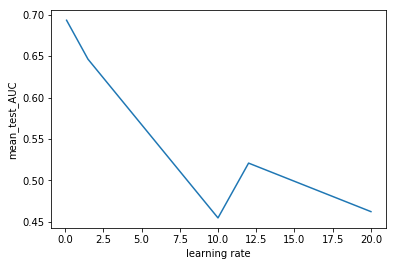

In [88]:
y_ax = clf5.cv_results_['mean_test_score']
x_ax = ma.getdata(clf5.cv_results_['param_learning_rate'])
plt.plot(x_ax, y_ax)
plt.ylabel("mean_test_AUC")
plt.xlabel("learning rate")

### Possibilities of the Future improvements;

1. We can try out Bi-grams, Tri-grams for the sequential learning by the XGBoost ML model. CountVectorizer has the option of tokenizing the words into the n-gram 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

2. We can tune the embedding-size, number of max-feature from counter-vectorizer along with the ML model hyper-parameters tuning. 

3. We can also apply TF-IDF vectorizer instead of countvectorizer in which each of the tokens can be encoded with the TF-IDF weights. TFIDF shows the relative importance of a word or phrase in a document or a set of documents in comparison to the rest of your corpus. TF means the term frequency across all the corpus. IDF means the inverse document frequency which takes into the account specificity of the term in the specific documents. For example, words related to medical terms can only appear in the medical related documents but may not neccessarily be frequent words across the entire corpus. Hence IDF of the specific terms are used to put the weights.